In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import pandas as pd

np.random.seed(42) # For reproducibilty

class Bandit:
    """
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    """
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [2]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        av_best = 0
        for r in trange(runs):
            bandit.reset()
            av_best += bandit.q_true[bandit.best_action]
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards, av_best

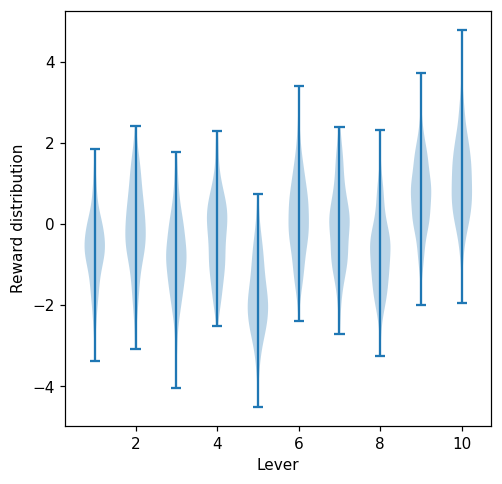

In [3]:
plt.figure(figsize=(5, 5), dpi= 110, facecolor='w', edgecolor='k')
plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
plt.xlabel("Lever")
plt.ylabel("Reward distribution")
plt.show()

In [ ]:
# Hyperparameters
runs = 50
time = 50

100%|██████████| 2/2 [00:00<00:00, 1833.17it/s]


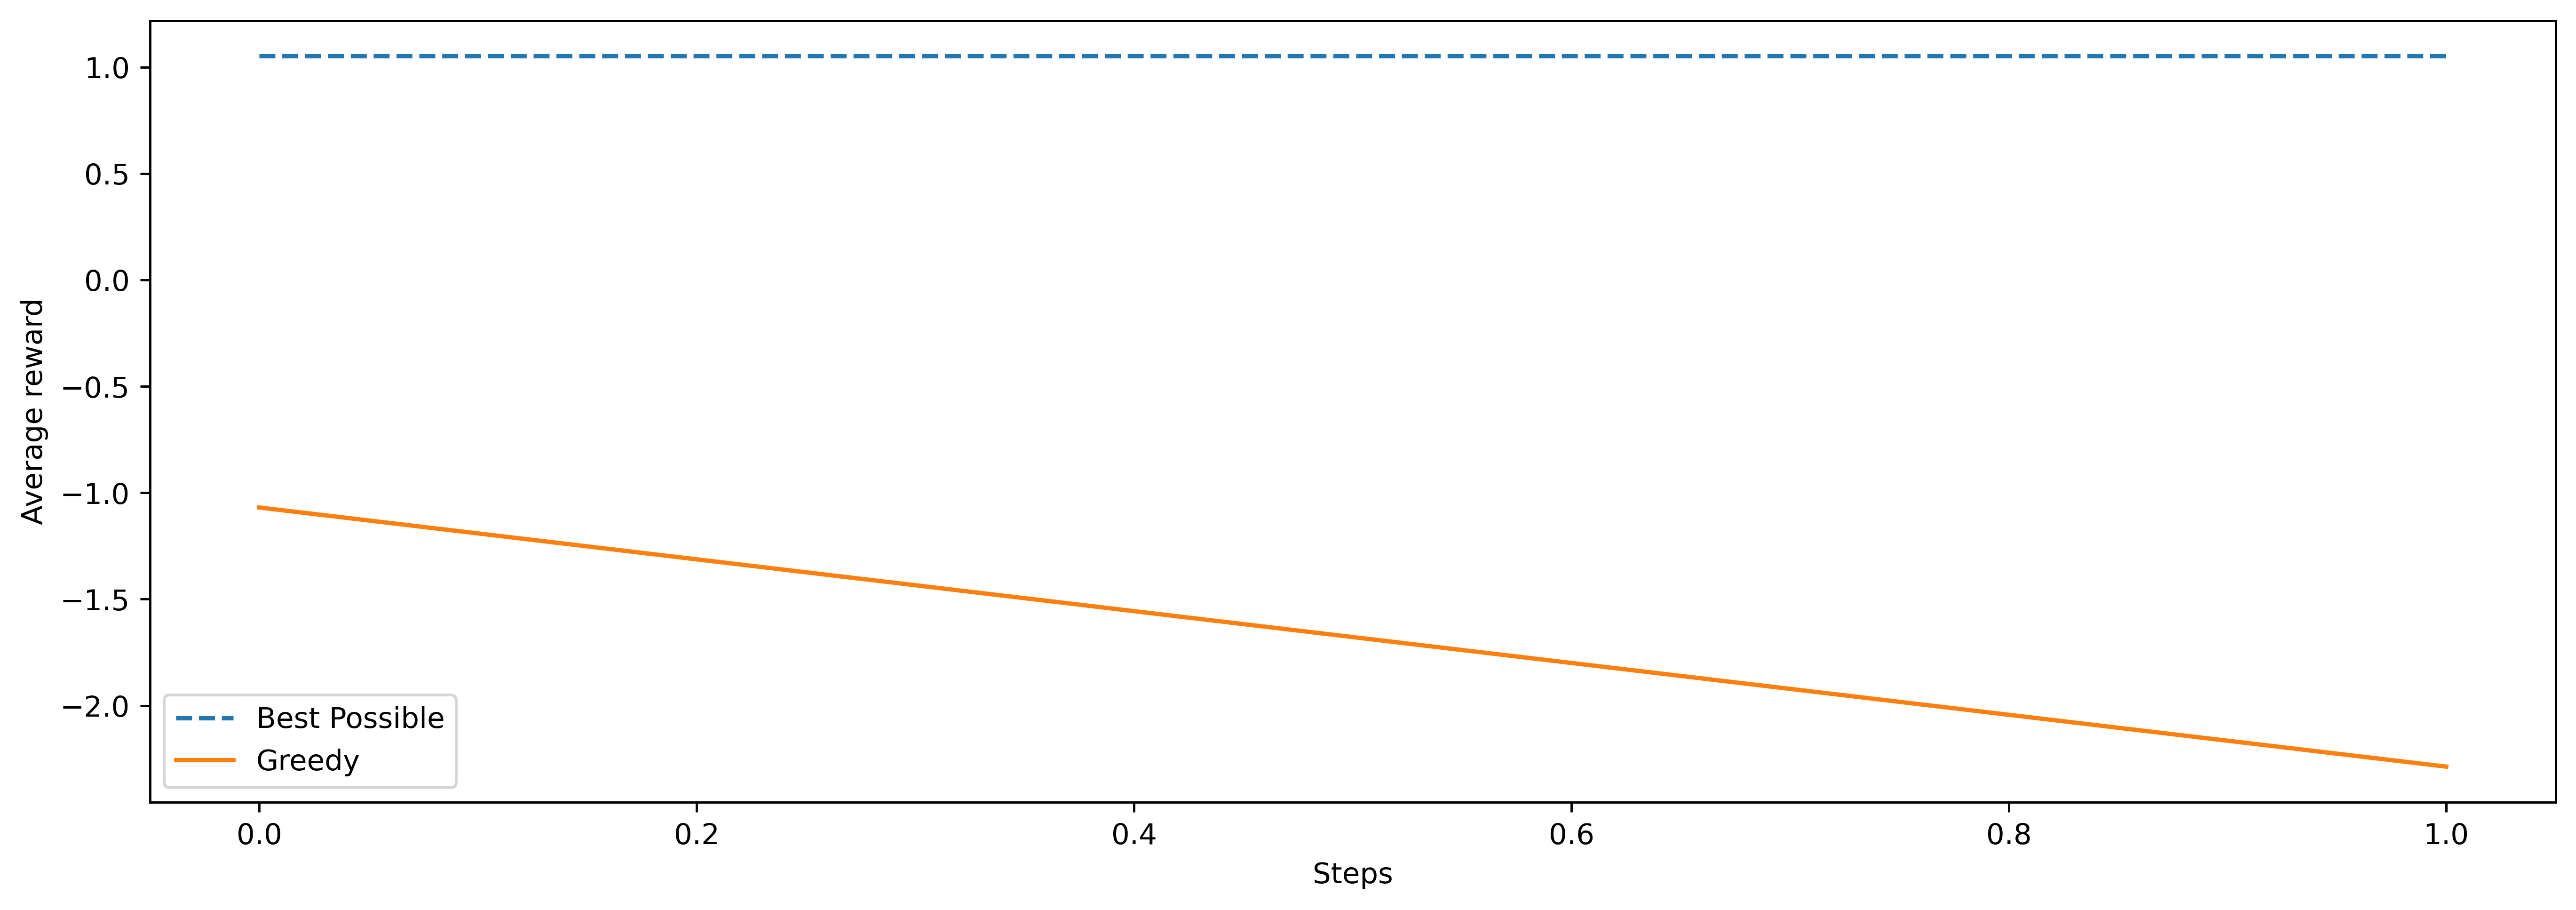

In [ ]:
# Greedy Policy
bandits = []
bandits.append(Bandit(epsilon=0, sample_averages=True))
_, average_rewards, av_best = simulate(runs, time, bandits)

plt.figure(figsize=(15, 5), dpi= 440, facecolor='w', edgecolor='k')
plt.plot([av_best / runs for _ in range(time)], linestyle="--")
plt.plot(average_rewards[0], label='Greedy')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend(["Best Possible", "Greedy"])
plt.show() 

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 113.16it/s]


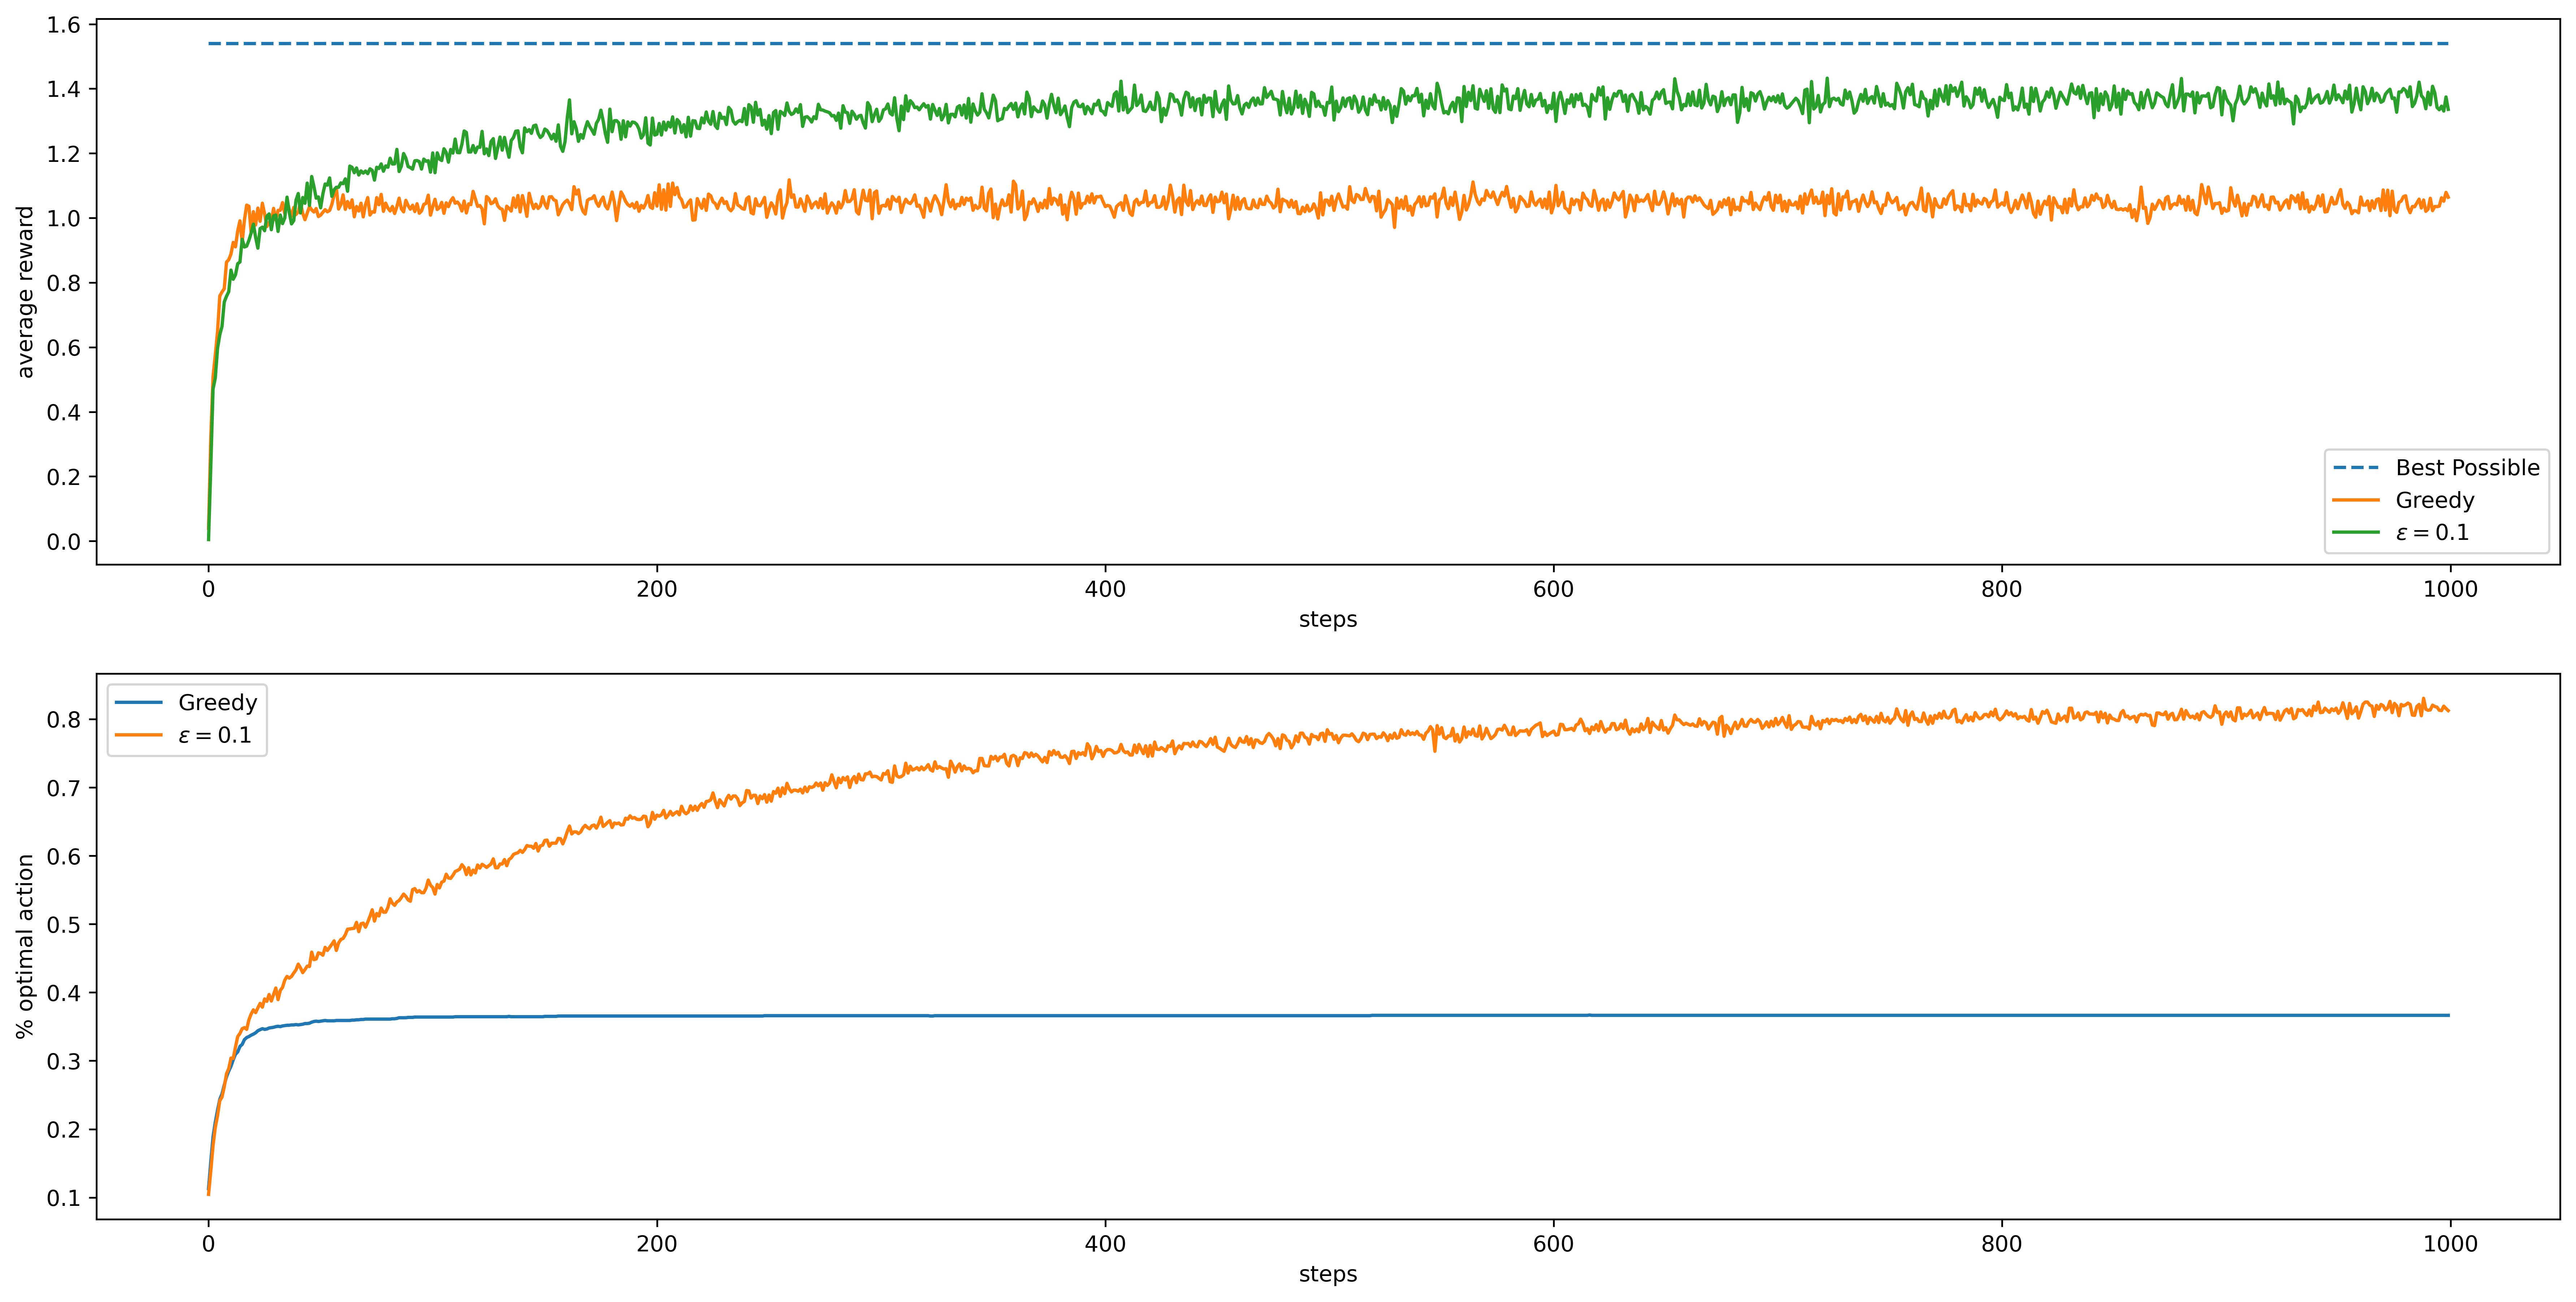

In [ ]:
# Greedy v Epsilon-Greedy
epsilons = [0, 0.1]
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards, av_best = simulate(runs, time, bandits)

plt.figure(figsize=(20, 10), dpi= 440, facecolor='w', edgecolor='k')

plt.subplot(2, 1, 1)
plt.plot([av_best / runs for _ in range(time)], linestyle="--")
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend(["Best Possible", "Greedy", r'$\epsilon=0.1$'])

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend(["Greedy", r'$\epsilon=0.1$'])
plt.show()

100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]

<class 'numpy.ndarray'>
(4, 1000)


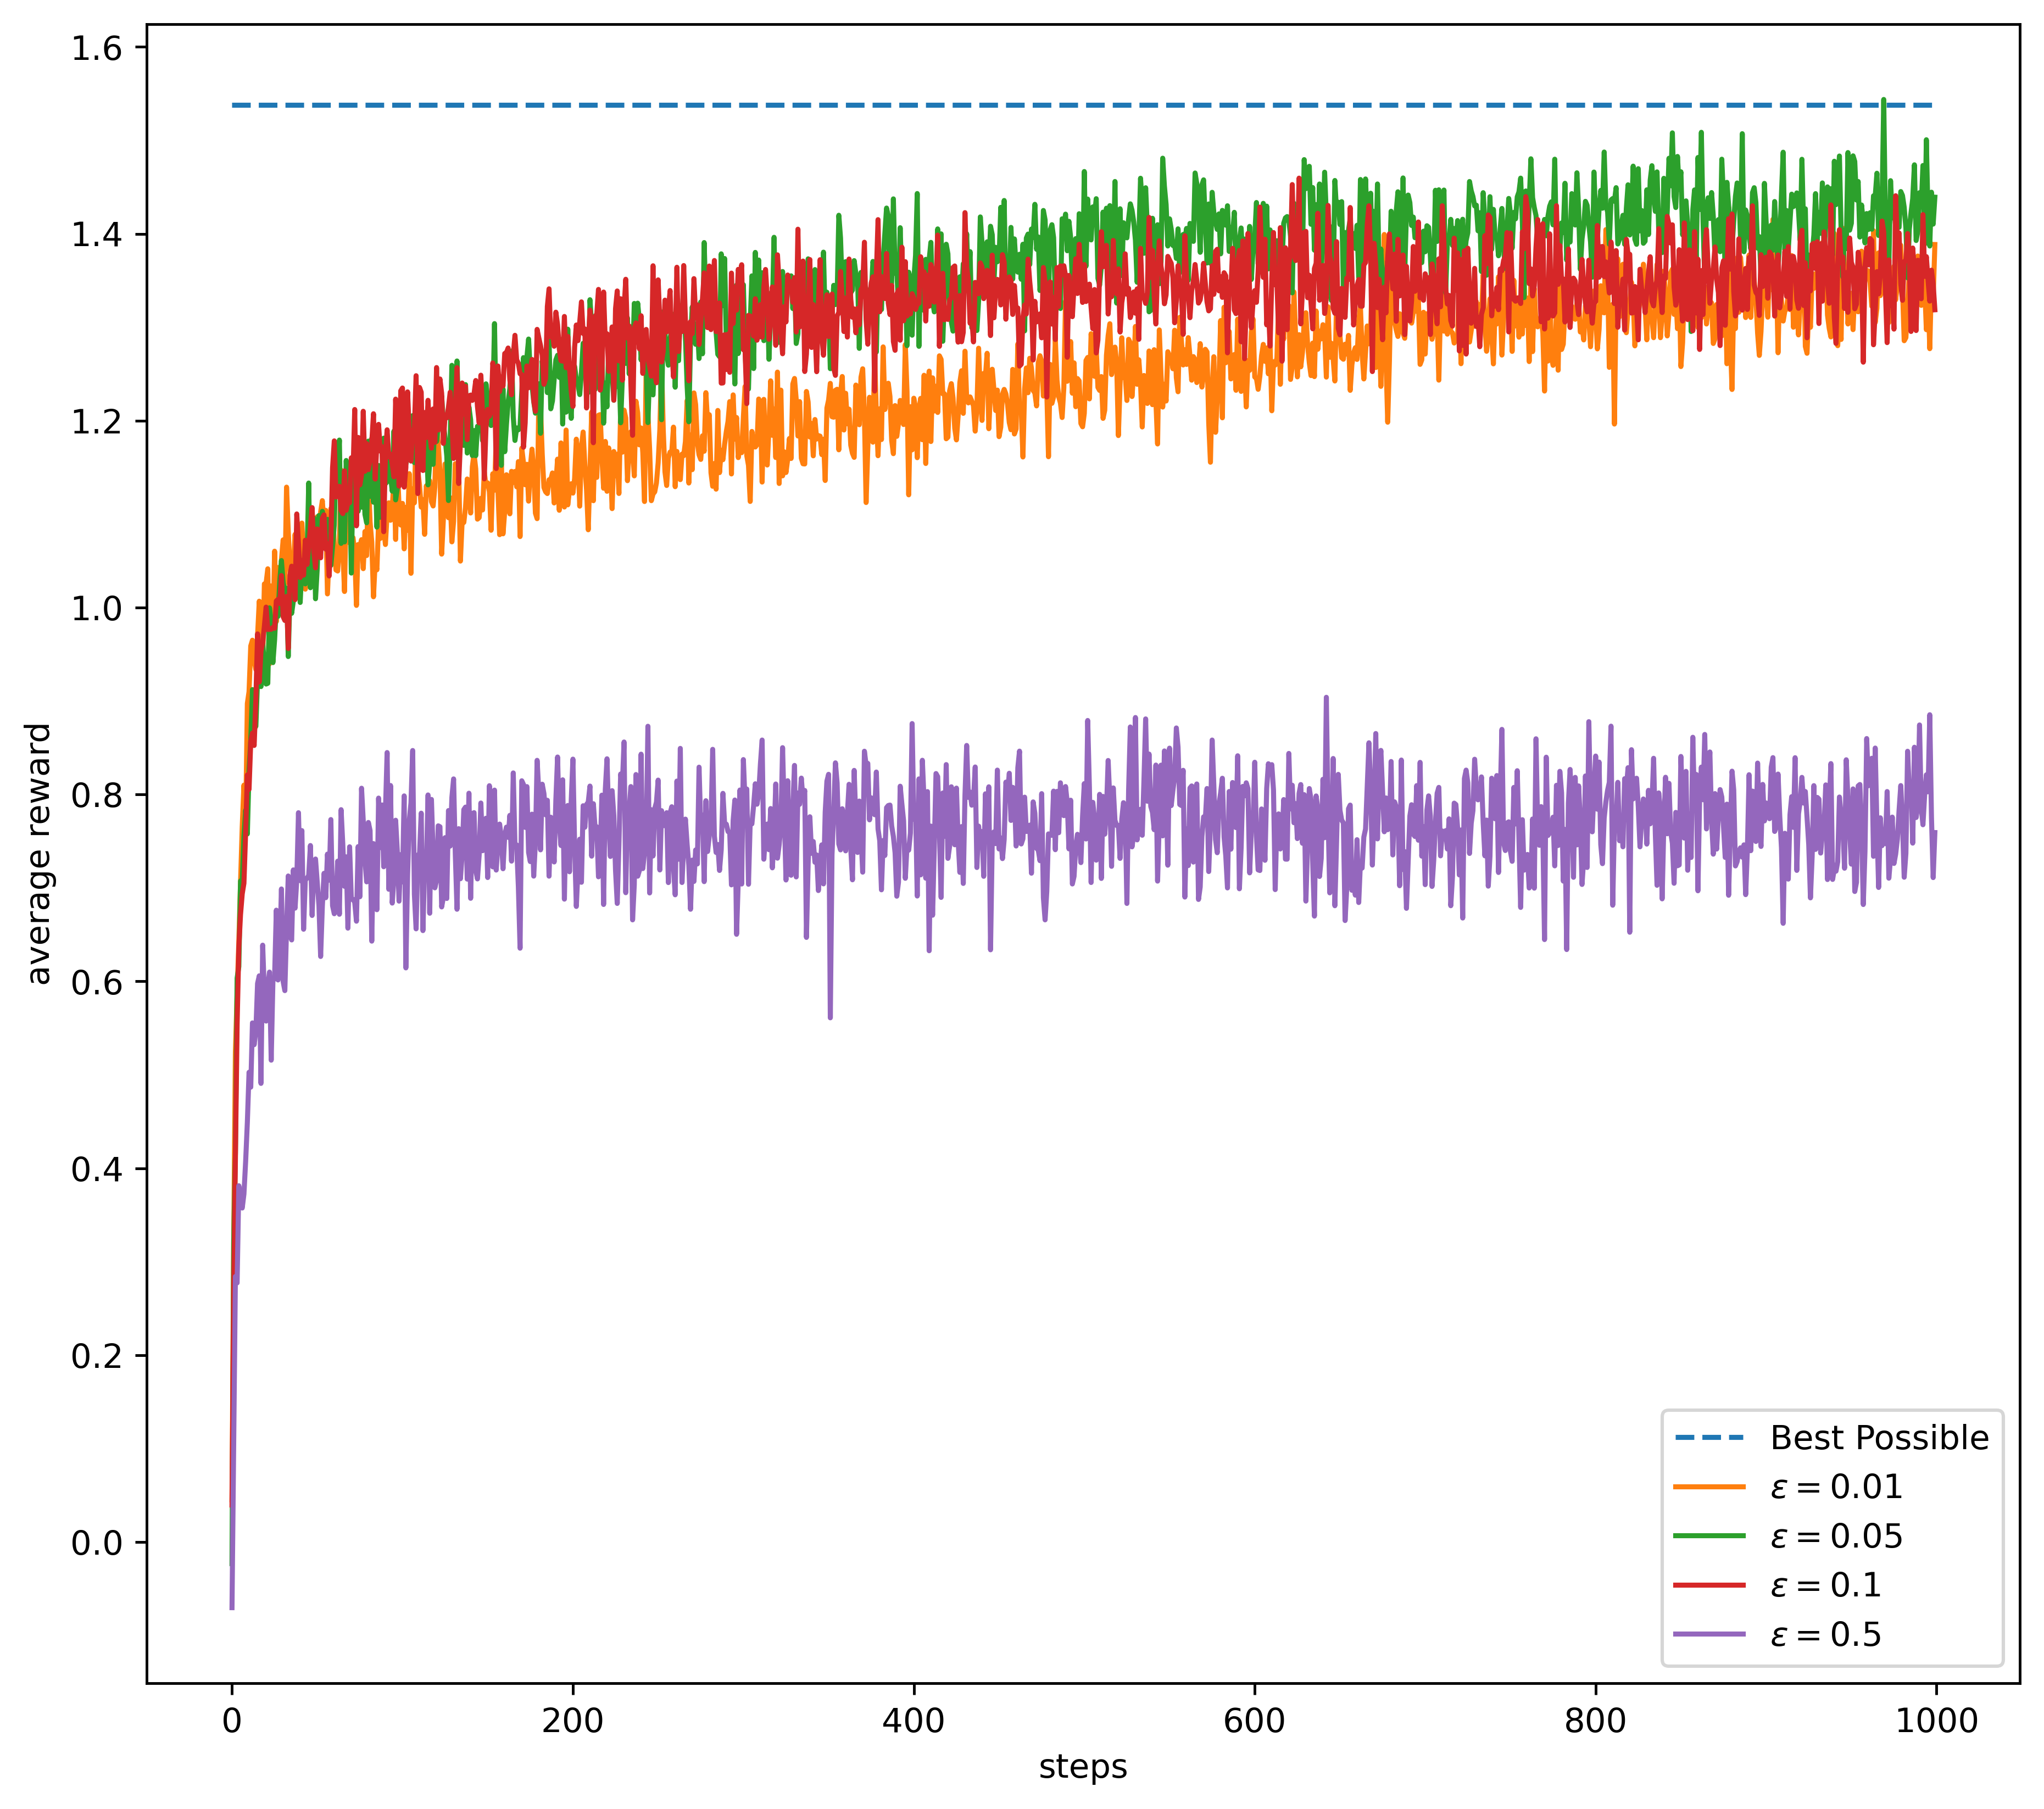

In [ ]:
# Comparing various epsilon values
epsilons = [0.01, 0.05, 0.1, 0.5]
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards, av_best = simulate(runs, time, bandits)
print(type(best_action_counts))
print(best_action_counts.shape)
plt.figure(figsize=(10, 20), dpi= 440, facecolor='w', edgecolor='k')

plt.subplot(2, 1, 1)
plt.plot([av_best / runs for _ in range(time)], linestyle="--")
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend(["Best Possible", r'$\epsilon=0.01$', r'$\epsilon=0.05$', r'$\epsilon=0.1$', r'$\epsilon=0.5$'])

# plt.subplot(2, 1, 2)
# for eps, counts in zip(epsilons, best_action_counts):
#     plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
# plt.xlabel('steps')
# plt.ylabel('% optimal action')
# plt.legend()
# plt.show()


We will now vary the arms, epsilon and number of runs to view them visually and see if any analysis can be drawn from them

In [5]:
#Time=1000
# Hyperparameters
runs = 100
time = 1000



epsilon1= [0,0.01, 0.05, 0.1,0.2, 0.5]
arms=[10,20,30,40,50,60,70,80,90]
df_check=pd.DataFrame()

for k in arms:
  bandits = [Bandit(k_arm=k,epsilon=eps, sample_averages=True) for eps in epsilon1] 
  best_action_counts, rewards, av_best = simulate(runs, time, bandits)
  rewards_arms=[rewards[0,-1],rewards[1,-1],rewards[2,-1],rewards[3,-1],rewards[4,-1],rewards[5,-1]]
  rewards_df=pd.DataFrame(rewards_arms)
  df_check=pd.concat([df_check,rewards_df], ignore_index=True,axis=1)

df_check.columns =arms

df_check.index=epsilon1
print("\n",df_check)




100%|██████████| 100/100 [00:02<00:00, 37.58it/s]


             10        20        30  ...        70        80        90
0.00  0.948878  0.999883  0.939549  ...  1.129188  1.011161  0.997368
0.01  1.356784  1.450004  1.482038  ...  1.385334  1.432882  1.483222
0.05  1.386879  1.536518  1.882453  ...  1.842349  1.941169  1.965808
0.10  1.457971  1.770961  1.958066  ...  2.131484  2.131449  2.010493
0.20  1.212569  1.517881  1.824457  ...  1.802400  1.854384  1.874636
0.50  0.781705  0.681935  0.966197  ...  1.228875  1.377294  1.374294

[6 rows x 9 columns]


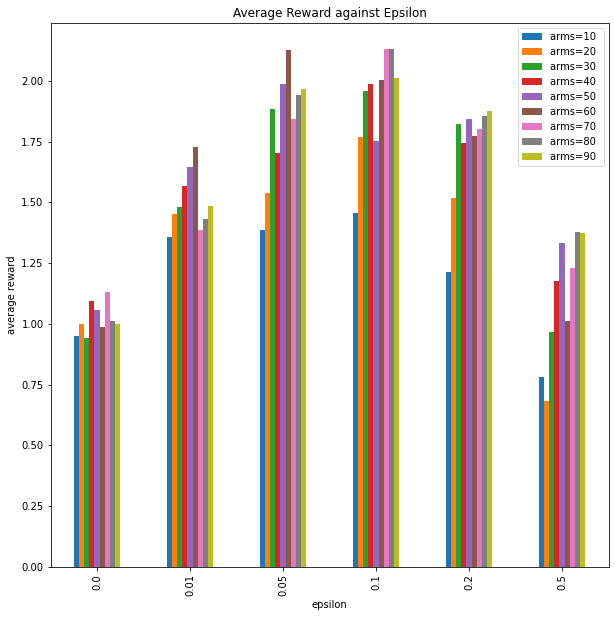

In [33]:

# plt.figure()
a=df_check.plot( figsize=(10, 10),xlabel='epsilon',ylabel='average reward',title='Average Reward against Epsilon',kind='bar')
plt.legend(['arms=10 ','arms=20 ','arms=30 ','arms=40 ','arms=50 ','arms=60 ','arms=70 ','arms=80 ','arms=90 '],loc='best')



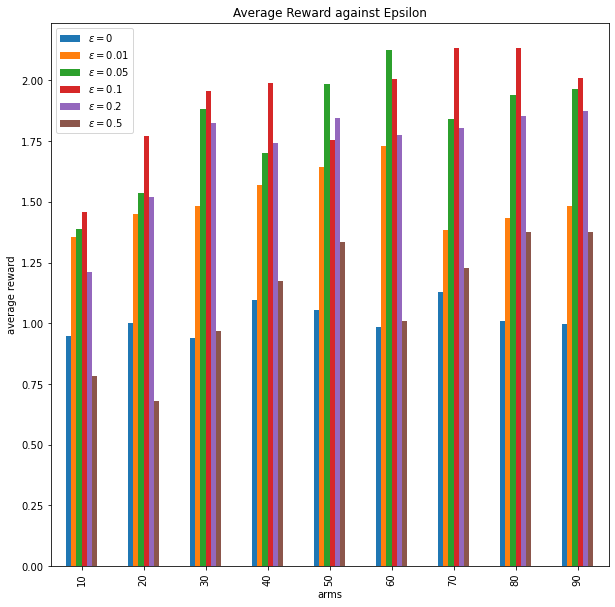

In [31]:
df_check_t=df_check.transpose()
df_check_t.plot( figsize=(10, 10),xlabel='arms',ylabel='average reward',title='Average Reward against Epsilon',kind='bar')
plt.legend([r'$\epsilon=0$',r'$\epsilon=0.01$',r'$\epsilon=0.05$',r'$\epsilon=0.1$',r'$\epsilon=0.2$',r'$\epsilon=0.5$'],loc='best')


Varying Time for Constant Arms

In [9]:
runs = 100


epsilon1= [0,0.01, 0.05, 0.1,0.2, 0.5]
arms=10
time=[100,200,300,400,500,600,700,800,900,1000]
df_arms=pd.DataFrame()

for t in time:
  bandits = [Bandit(k_arm=arms,epsilon=eps, sample_averages=True) for eps in epsilon1] 
  best_action_counts, rewards, av_best = simulate(runs, t, bandits)
  rewards_arms=[rewards[0,-1],rewards[1,-1],rewards[2,-1],rewards[3,-1],rewards[4,-1],rewards[5,-1]]
  rewards_df=pd.DataFrame(rewards_arms)
  df_arms=pd.concat([df_arms,rewards_df], ignore_index=True,axis=1)

df_arms.columns =time

df_arms.index=epsilon1
print("\n",df_arms)


100%|██████████| 100/100 [00:02<00:00, 37.12it/s]


           100       200       300   ...      800       900       1000
0.00  1.275874  1.143369  0.983168  ...  0.898360  1.173316  0.848984
0.01  1.112452  1.118231  1.127585  ...  1.326289  1.488356  1.326705
0.05  1.119470  1.252492  1.562668  ...  1.411747  1.349922  1.495777
0.10  0.937844  1.446476  1.353220  ...  1.418793  1.360140  1.342016
0.20  1.037629  1.394483  1.119316  ...  1.115806  1.343188  1.293683
0.50  0.569897  0.943429  0.825207  ...  0.561956  0.780652  0.649269

[6 rows x 10 columns]


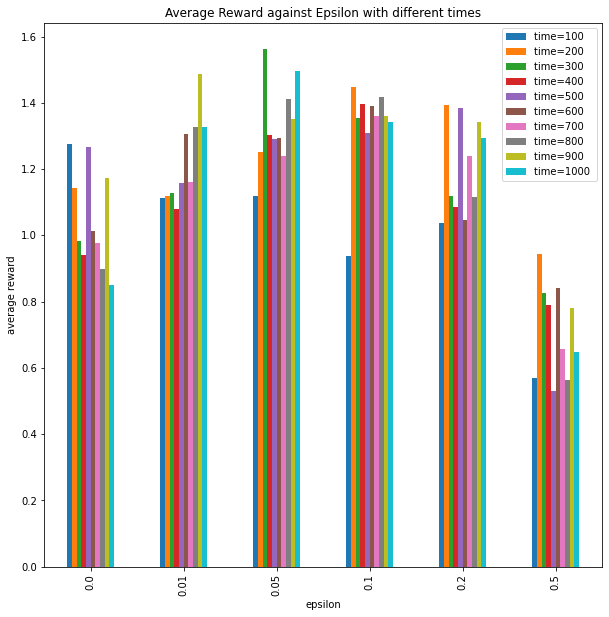

In [30]:
df_arms.plot( figsize=(10, 10),xlabel='epsilon',ylabel='average reward',title='Average Reward against Epsilon with different times',kind='bar')
#Arms constant=10
plt.legend(['time=100 ','time=200 ','time=300 ','time=400 ','time=500 ','time=600 ','time=700 ','time=800 ','time=900 ','time=1000 '])




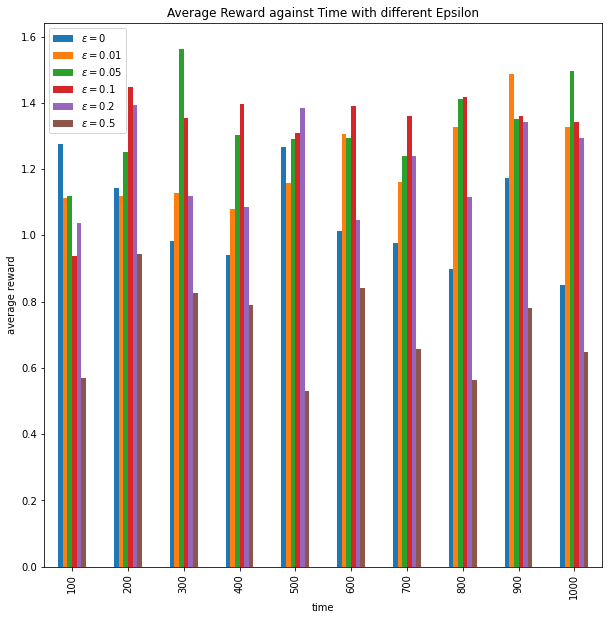

In [26]:
df_arms_t=df_arms.transpose()
df_arms_t.plot( figsize=(10, 10),xlabel='time',ylabel='average reward',title='Average Reward against Time with different Epsilon',kind='bar',legend=True,label='Epsilon')
plt.legend([r'$\epsilon=0$',r'$\epsilon=0.01$',r'$\epsilon=0.05$',r'$\epsilon=0.1$',r'$\epsilon=0.2$',r'$\epsilon=0.5$'])


Varying Time for Constant Epsilon

In [16]:
runs = 1000

time=[100,200,300,400,500,600,700,800,900,1000]
epsilon1= 0.01
arms=[10,20,30,40,50,60,70,80,90]
df_epsilon=pd.DataFrame()

for t in time:
  bandits = [Bandit(k_arm=k,epsilon=epsilon1, sample_averages=True) for k in arms] 
  best_action_counts, rewards, av_best = simulate(runs, t, bandits)
  rewards_arms=[rewards[0,-1],rewards[1,-1],rewards[2,-1],rewards[3,-1],rewards[4,-1],rewards[5,-1],rewards[6,-1],rewards[7,-1],rewards[8,-1]]
  rewards_df=pd.DataFrame(rewards_arms)
  df_epsilon=pd.concat([df_epsilon,rewards_df], ignore_index=True,axis=1)

df_epsilon.columns =time

df_epsilon.index=arms
print("\n",df_epsilon)

100%|██████████| 1000/1000 [00:36<00:00, 27.28it/s]


         100       200       300   ...      800       900       1000
10  1.104022  1.035631  1.202356  ...  1.319074  1.279050  1.266718
20  1.151861  1.163350  1.183742  ...  1.398730  1.392964  1.472885
30  1.106342  1.142102  1.248613  ...  1.408881  1.504607  1.487694
40  1.059808  1.125569  1.273916  ...  1.457621  1.519359  1.455669
50  1.099264  1.169340  1.237908  ...  1.434961  1.471614  1.488722
60  1.077188  1.178885  1.209497  ...  1.473835  1.530426  1.481317
70  1.136017  1.231037  1.267510  ...  1.401154  1.502793  1.473543
80  1.123573  1.204714  1.214423  ...  1.463497  1.545762  1.571475
90  1.136453  1.264815  1.247482  ...  1.509272  1.475977  1.479696

[9 rows x 10 columns]


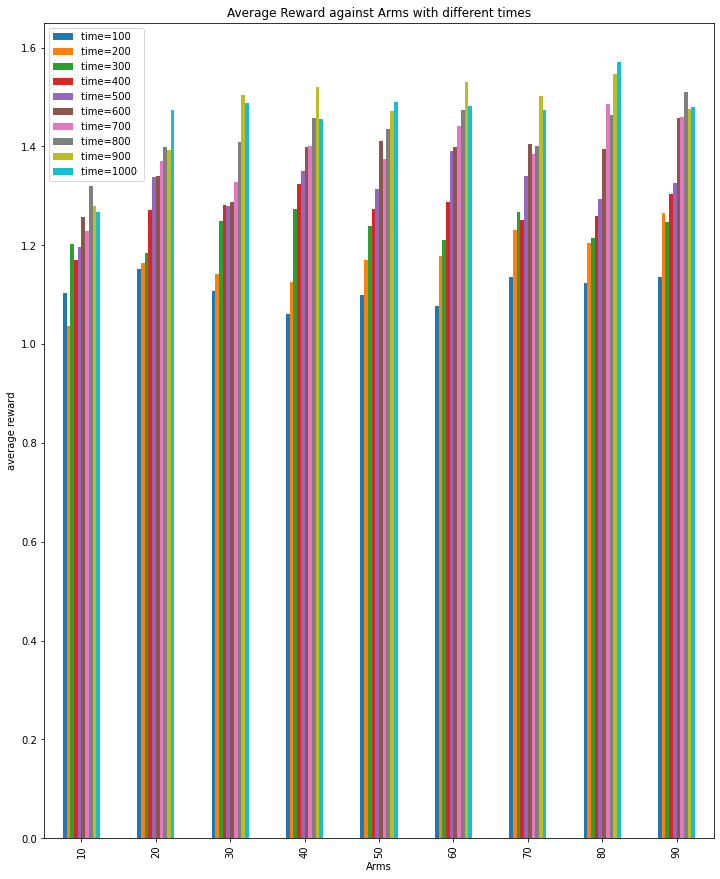

In [39]:
df_epsilon.plot( figsize=(12, 15),xlabel='Arms',ylabel='average reward',title='Average Reward against Arms with different times',kind='bar')
#Epsilon Constant=0.01
plt.legend(['time=100 ','time=200 ','time=300 ','time=400 ','time=500 ','time=600 ','time=700 ','time=800 ','time=900 ','time=1000 '],loc='best')


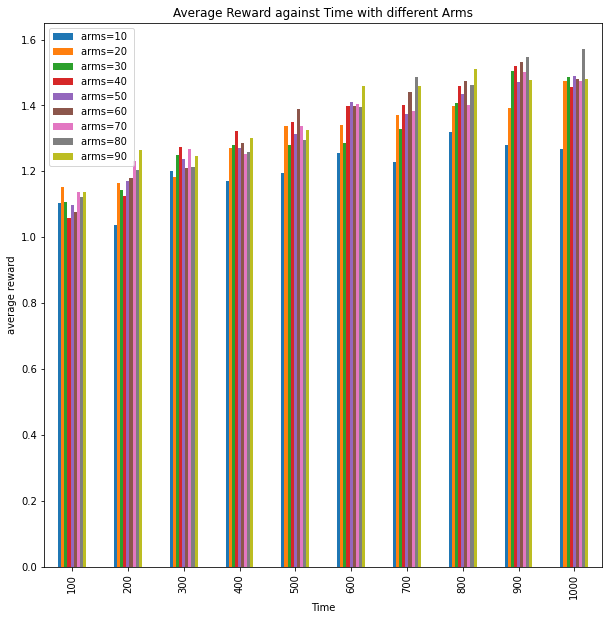

In [34]:

df_epsilon_t=df_epsilon.transpose()
df_epsilon_t.plot( figsize=(10, 10),xlabel='Time',ylabel='average reward',title='Average Reward against Time with different Arms',kind='bar')
plt.legend(['arms=10 ','arms=20 ','arms=30 ','arms=40 ','arms=50 ','arms=60 ','arms=70 ','arms=80 ','arms=90 '],loc='best')